# Fitting a Stage-Discharge Rating using a Segmented
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/ratingcurve/blob/master/notebooks/segmented-power-law-demo.ipynb)  

There are several approaches to fitting a stage-discharge rating curve. 
The first section of this notebook demonstrates the classic approach, 
which is to use a segmented power law.

In [1]:
# # Only run this cell to setup Google Colab. It will take a minute.
# %%capture
# # Specific repo version used in this notebook
# !pip install pymc==5.0.2
#
# # Colab needs this
# %env MKL_THREADING_LAYER=GNU
#
# # install ratingcurve library
# !pip install git+https://github.com/thodson-usgs/ratingcurve.git

In [2]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
from ratingcurve.ratingmodel import PowerLawRating, SplineRating

## Load Data

In [3]:
# load tutorial data
from ratingcurve import data
data.list()

['chalk artificial',
 'co channel',
 'green channel',
 'provo natural',
 '3-segment simulated']

and load a specific dataset.

In [4]:
df = data.load('green channel')
df.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


Text(0, 0.5, 'Stage (ft)')

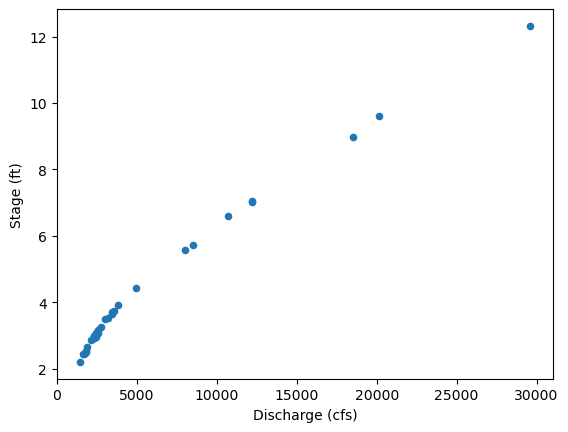

In [5]:
# plot the data
ax = df.plot.scatter(x='q', y='stage', marker='o')
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

## Setup model
Setup a rating model. This make take a minute while the model compiles.

In [6]:
segments = 2
powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'], 
                             q_sigma=df['q_sigma'],
                             segments=segments,
                             prior={'distribution':'uniform'})

then fit the model using variational inference (this will be slower on the first run). Set the number of iterations `n` such that the model stops after the loss stops decreasing.

In [7]:
with powerrating:
    mean_field = pm.fit(method='advi', n=120_000)
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -49.273


Once fit, we can evaluate the model by plotting the rating curve.

/mnt/c/Users/thodson/OneDrive - DOI/Desktop/Projects/software-release/ratingcurve/ratingcurve/ratingmodel.py:318: RuntimeWarning: invalid value encountered in log
  b1 = np.where(h_tile <= hs, clips, np.log(h_tile-h0))


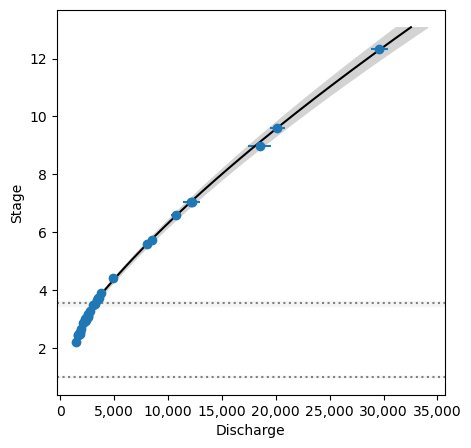

In [8]:
powerrating.plot(trace)

or as a table of stage-discharge values.

In [9]:
table = powerrating.table(trace)
table.head()

/mnt/c/Users/thodson/OneDrive - DOI/Desktop/Projects/software-release/ratingcurve/ratingcurve/ratingmodel.py:318: RuntimeWarning: invalid value encountered in log
  b1 = np.where(h_tile <= hs, clips, np.log(h_tile-h0))


,stage,discharge,sigma
0,2.20,1365.65,1.0154
1,2.21,1378.06,1.0154
2,2.22,1390.47,1.0153
3,2.23,1402.89,1.0153
4,2.24,1415.32,1.0152


## Exercise
What happens if we choose the wrong number of segments? 
Increase the number of segments by one and rerun the model.
We can use this approach to select the correct number of segments;
more on this topic in the [model evaluation notebook]()(https://github/thodson-usgs/ratingcurve/blob/master/notebooks/model-evaluation-demo.ipynb) 

## Simulated Example
This example uses a simulated rating curve, which allows you to test how different sampling schemes affect the rating curve fit.

First, open the `simulated_rating` tutorial dataset.

In [10]:
sim_df = data.load('3-segment simulated')
print('The simulated rating contains {} observations'.format(len(sim_df)))

The simulated rating contains 763 observations


This rating contains observations of every 0.01 inch. increment in stage, which is much more than we'd have for a natural rating.
Try sampling to `n=15` or `n=30` and see how that affects the model fit.

Text(0, 0.5, 'Stage (ft)')

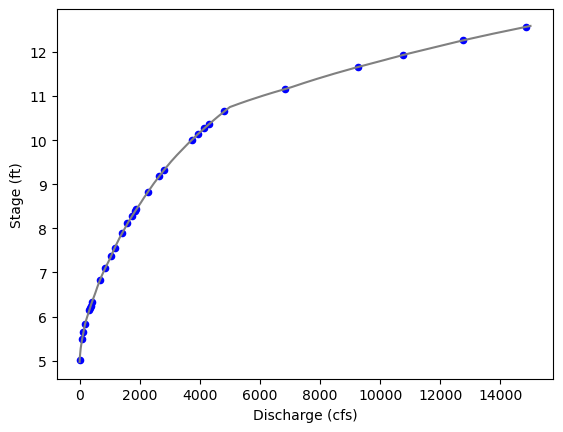

In [11]:
# subsample the simulated rating curve
n = 30
df = sim_df.sample(n, random_state=12345)

ax = sim_df.plot(x='q', y='stage', color='grey', ls='-', legend=False)
df.plot.scatter(x='q', y='stage', marker='o', color='blue', ax=ax)
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

Setup a rating model with 3 segments

In [12]:
segments = 3
powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'],
                             q_sigma=None,
                             segments=segments,
                             prior={'distribution':'uniform'})
                             #prior={'distribution':'normal', 'mu':[5, 8, 11], 'sigma':[1, 1, 0.2]})

now fit the model using ADVI

In [13]:
with powerrating:
    mean_field = pm.fit(method='advi', n=150_000) #increase n as necessary
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -55.501


and visualize the results.

/mnt/c/Users/thodson/OneDrive - DOI/Desktop/Projects/software-release/ratingcurve/ratingcurve/ratingmodel.py:318: RuntimeWarning: invalid value encountered in log
  b1 = np.where(h_tile <= hs, clips, np.log(h_tile-h0))


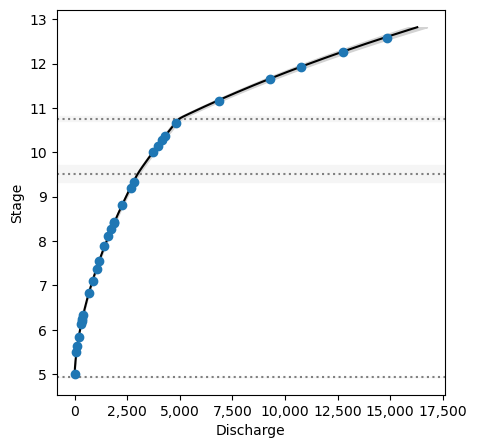

In [14]:
powerrating.plot(trace, None)

In [15]:
az.summary(trace, var_names=["w", "a", "sigma", "hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.968,0.001,0.965,0.971,0.000,0.000,4363.0,4715.0,NaN
w[1],0.072,0.004,0.065,0.079,0.000,0.000,5119.0,4678.0,NaN
w[2],0.308,0.006,0.297,0.319,0.000,0.000,4866.0,4850.0,NaN
a,-0.999,0.002,-1.003,-0.996,0.000,0.000,5085.0,4869.0,NaN
sigma,0.010,0.001,0.007,0.012,0.000,0.000,4792.0,4901.0,NaN
"hs[0, 0]",4.932,0.001,4.930,4.933,0.000,0.000,5105.0,4897.0,NaN
"hs[1, 0]",9.517,0.098,9.326,9.694,0.001,0.001,4540.0,4761.0,NaN
"hs[2, 0]",10.759,0.030,10.702,10.814,0.000,0.000,5003.0,4861.0,NaN


Fitting this model is tricky. If the fit appears poor, here are some steps to try.
1. rerun the model, a new
1. try increasing the number of iterations.
1. try a strong prior on the breakpoints. For example, try `prior={'distribution':'normal', 'mu':[5, 9.5, 10.5], 'sigma':[1, 1, 0.2]})`, which implies we know the true breakpoint within +-0.5 ft.
1. finally, try fitting the model with another method.

ADVI typically underestimates uncertainty and struggles with multi-modal distributions.
NUTS may give better results but will be substantially slower to fit.

In [16]:
# NUTS example. This may take several minutes, depending on your CPU.
# n = 4
# with powerrating:
#     trace = pm.sample(tune=1500, chains=n, cores=n, target_accept=0.95)
# 
# powerrating.plot(trace)

## Parameterization
The segmented power law is defined as:

\begin{align}
    \log(Q) = a + \sum_{i=1}^{n} b_i \log(x - x_{o,i}) H_i(x - x_{o,i})
\end{align}
where
$Q$ is a vector discharge, \
$n$ is the number of breakpoints in the rating, \
$a$ and $b$ are model parameters, \
$x$ is a vector of stage observations, \
$x_o$ is a vector of breakpoints, and \
$H$ is the Heaviside function. 

In a standard linear model $b$ represents the slope of the function with respect the input.
In the segmented power law $b_o$ is the slope and each subsequent $b_i$ are adjustment to the base slope for each segment.